# 🎯 Weekend Effect Analysis

**Objectif**: Analyser l'impact du weekend sur les patterns de rating et découvrir les rythmes comportementaux des utilisateurs.

## 🔍 Questions exploratoires:
- Les gens notent-ils différemment quand ils ont du temps libre ?
- Quel est le "jour le plus dur" vs "jour le plus cool" ?
- Le weekend change-t-il la FORME des distributions de ratings ?
- L'effet weekend évolue-t-il dans le temps ?
- Quels sont les rythmes naturels d'usage de la plateforme ?

In [1]:
# Imports et chargement utilitaires
import sys
from pathlib import Path

# Trouve automatiquement le dossier qui contient '00_eda/_data_utils'
cwd = Path.cwd()
repo_root = cwd
while repo_root != repo_root.parent:
    if (repo_root / '00_eda' / '_data_utils').exists():
        break
    repo_root = repo_root.parent

sys.path.insert(0, str(repo_root / '00_eda'))

# 🎯 Chargement des fonctions utilitaires depuis le fichier Python (plus robuste)
from _data_utils import *

# Imports spécifiques analyses
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu, chi2_contingency, kruskal
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

print("✅ Imports terminés - Module data_utils chargé - Prêt pour l'analyse Weekend!")

✅ _data_utils module chargé (common + ratings + recipes)
✅ Imports terminés - Module data_utils chargé - Prêt pour l'analyse Weekend!


In [2]:
# Chargement et préparation des données
print("🔄 Chargement des données...")
df_clean = load_clean_interactions()
print(f"✅ Données chargées: {df_clean.shape}")

# Vérification des colonnes weekend
print(f"\n📊 Colonnes disponibles:")
print(f"Weekend: {'is_weekend' in df_clean.columns}")
print(f"Weekday: {'weekday' in df_clean.columns}")

# Aperçu rapide
print(f"\n🎯 Répartition weekend vs semaine:")
weekend_split = df_clean.group_by("is_weekend").agg([
    pl.len().alias("count"),
    pl.col("rating").mean().alias("mean_rating")
])
print(weekend_split.to_pandas())

🔄 Chargement des données...
✅ Données chargées: (1071520, 12)

📊 Colonnes disponibles:
Weekend: True
Weekday: True

🎯 Répartition weekend vs semaine:
   is_weekend   count  mean_rating
0           0  625668     4.661063
1           1  445852     4.662110


## 🎯 Analyse 1: Weekend vs Weekday Ratings

**Objectif exploratoire**: Tester si le weekend rend les gens plus indulgents/détendus  
**Question business**: Les gens notent-ils différemment quand ils ont du temps libre ?  
**Découverte attendue**: Weekend = ratings plus élevés (mood positif)

In [3]:
# ✅ VALIDATION RAPIDE - Données propres (ratings 1-5 uniquement)
print("✅ VALIDATION - Qualité des données:")
print(f"📊 {df_clean.shape[0]:,} interactions avec ratings valides")

# Vérification rapide: aucun rating = 0
zero_check = df_clean.filter(pl.col("rating") == 0).shape[0]
print(f"🔍 Ratings = 0: {zero_check} (attendu: 0)")

# Distribution propre
rating_range = [df_clean["rating"].min(), df_clean["rating"].max()]
print(f"⭐ Range ratings: {rating_range} (attendu: [1, 5])")
print(f"📈 Rating moyen: {df_clean['rating'].mean():.3f}")

assert zero_check == 0, "❌ ERREUR: Des ratings = 0 détectés!"
assert rating_range == [1, 5], f"❌ ERREUR: Range invalide {rating_range}"
print("🎯 Données validées - Prêt pour analyse Weekend!")

✅ VALIDATION - Qualité des données:
📊 1,071,520 interactions avec ratings valides
🔍 Ratings = 0: 0 (attendu: 0)
⭐ Range ratings: [1, 5] (attendu: [1, 5])
📈 Rating moyen: 4.661
🎯 Données validées - Prêt pour analyse Weekend!


In [4]:
# Préparation DataFrame weekend_comparison
weekend_comparison = df_clean.group_by("is_weekend").agg([
    pl.col("rating").mean().alias("mean_rating"),
    pl.col("rating").median().alias("median_rating"),
    pl.col("rating").std().alias("std_rating"),
    pl.len().alias("n_interactions")
]).sort("is_weekend").to_pandas()

weekend_comparison["category"] = ["Semaine", "Weekend"]
print("📊 Statistiques descriptives:")
display(weekend_comparison)

# Test Mann-Whitney U
weekend_ratings = df_clean.filter(pl.col("is_weekend") == 1)["rating"].to_numpy()
weekday_ratings = df_clean.filter(pl.col("is_weekend") == 0)["rating"].to_numpy()

statistic, p_value = mannwhitneyu(weekend_ratings, weekday_ratings, alternative='two-sided')

# Calcul Cohen's d (effect size)
pooled_std = np.sqrt((np.std(weekend_ratings, ddof=1)**2 + np.std(weekday_ratings, ddof=1)**2) / 2)
cohens_d = (np.mean(weekend_ratings) - np.mean(weekday_ratings)) / pooled_std

print(f"\n🧪 Test Mann-Whitney U:")
print(f"Statistique: {statistic:.2f}")
print(f"P-valeur: {p_value:.4f}")
print(f"Cohen's d: {cohens_d:.4f}")
print(f"Interprétation: {'Différence significative' if p_value < 0.05 else 'Pas de différence significative'}")
print(f"Taille d'effet: {'Petite' if abs(cohens_d) < 0.2 else 'Moyenne' if abs(cohens_d) < 0.5 else 'Grande'}")

📊 Statistiques descriptives:


,is_weekend,mean_rating,median_rating,std_rating,n_interactions,category
0,0,4.661063,5.0,0.720533,625668,Semaine
1,1,4.662110,5.0,0.726576,445852,Weekend



🧪 Test Mann-Whitney U:
Statistique: 139861161924.00
P-valeur: 0.0011
Cohen's d: 0.0014
Interprétation: Différence significative
Taille d'effet: Petite


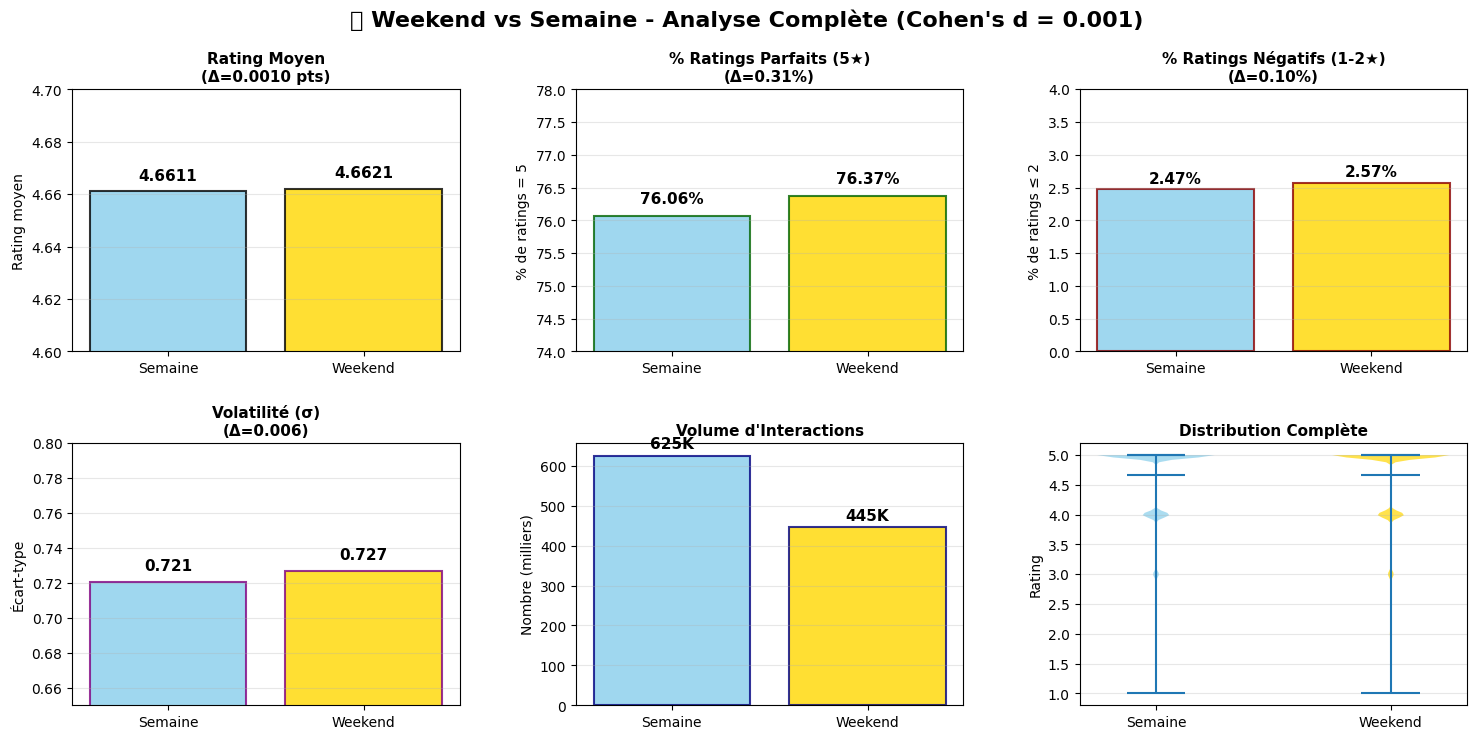

In [5]:
# Visualisation optimisée Weekend vs Semaine - Focus sur les vraies variations
fig = plt.figure(figsize=(18, 8))

from matplotlib.gridspec import GridSpec
gs = GridSpec(2, 3, figure=fig, hspace=0.35, wspace=0.3)

# Préparation des données
weekend_data = df_clean.filter(pl.col("is_weekend") == 1)["rating"].to_pandas()
weekday_data = df_clean.filter(pl.col("is_weekend") == 0)["rating"].to_pandas()

weekend_mean = weekend_data.mean()
weekday_mean = weekday_data.mean()
diff_mean = weekend_mean - weekday_mean

# Calcul % ratings parfaits
pct_5_weekend = (weekend_data == 5).sum() / len(weekend_data) * 100
pct_5_weekday = (weekday_data == 5).sum() / len(weekday_data) * 100

# Calcul % ratings négatifs
pct_neg_weekend = (weekend_data <= 2).sum() / len(weekend_data) * 100
pct_neg_weekday = (weekday_data <= 2).sum() / len(weekday_data) * 100

# Volatilité
std_weekend = weekend_data.std()
std_weekday = weekday_data.std()

# ============================================================================
# 1. COMPARAISON MOYENNES (échelle zoomée)
# ============================================================================
ax1 = fig.add_subplot(gs[0, 0])
categories = ["Semaine", "Weekend"]
means = [weekday_mean, weekend_mean]
colors = ["#87CEEB", "#FFD700"]

bars = ax1.bar(categories, means, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)

for i, (bar, mean) in enumerate(zip(bars, means)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.003,
             f'{mean:.4f}',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

ax1.set_title(f'Rating Moyen\n(Δ={diff_mean:.4f} pts)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Rating moyen', fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([4.60, 4.70])

# ============================================================================
# 2. % RATINGS PARFAITS (5★)
# ============================================================================
ax2 = fig.add_subplot(gs[0, 1])
pct_5_values = [pct_5_weekday, pct_5_weekend]

bars = ax2.bar(categories, pct_5_values, color=colors, edgecolor='darkgreen', linewidth=1.5, alpha=0.8)

for i, (bar, pct) in enumerate(zip(bars, pct_5_values)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.15,
             f'{pct:.2f}%',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

ax2.set_title(f'% Ratings Parfaits (5★)\n(Δ={pct_5_weekend-pct_5_weekday:.2f}%)', 
              fontsize=11, fontweight='bold')
ax2.set_ylabel('% de ratings = 5', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim([74, 78])

# ============================================================================
# 3. % RATINGS NÉGATIFS (1-2★)
# ============================================================================
ax3 = fig.add_subplot(gs[0, 2])
pct_neg_values = [pct_neg_weekday, pct_neg_weekend]

bars = ax3.bar(categories, pct_neg_values, color=colors, edgecolor='darkred', linewidth=1.5, alpha=0.8)

for i, (bar, pct) in enumerate(zip(bars, pct_neg_values)):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{pct:.2f}%',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

ax3.set_title(f'% Ratings Négatifs (1-2★)\n(Δ={pct_neg_weekend-pct_neg_weekday:.2f}%)', 
              fontsize=11, fontweight='bold')
ax3.set_ylabel('% de ratings ≤ 2', fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_ylim([0, 4])

# ============================================================================
# 4. VOLATILITÉ (controverse)
# ============================================================================
ax4 = fig.add_subplot(gs[1, 0])
std_values = [std_weekday, std_weekend]

bars = ax4.bar(categories, std_values, color=colors, edgecolor='purple', linewidth=1.5, alpha=0.8)

for i, (bar, std) in enumerate(zip(bars, std_values)):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{std:.3f}',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

ax4.set_title(f'Volatilité (σ)\n(Δ={std_weekend-std_weekday:.3f})', 
              fontsize=11, fontweight='bold')
ax4.set_ylabel('Écart-type', fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')
ax4.set_ylim([0.65, 0.80])

# ============================================================================
# 5. VOLUME D'INTERACTIONS
# ============================================================================
ax5 = fig.add_subplot(gs[1, 1])
volume_values = [len(weekday_data)/1000, len(weekend_data)/1000]

bars = ax5.bar(categories, volume_values, color=colors, edgecolor='navy', linewidth=1.5, alpha=0.8)

for i, (bar, vol) in enumerate(zip(bars, volume_values)):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 10,
             f'{int(vol)}K',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

ax5.set_title('Volume d\'Interactions', fontsize=11, fontweight='bold')
ax5.set_ylabel('Nombre (milliers)', fontsize=10)
ax5.grid(True, alpha=0.3, axis='y')

# ============================================================================
# 6. VIOLIN PLOT (distribution complète)
# ============================================================================
ax6 = fig.add_subplot(gs[1, 2])

violin_parts = ax6.violinplot([weekday_data, weekend_data], positions=[1, 2], 
                               showmeans=True, showmedians=True)
for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)

ax6.set_xticks([1, 2])
ax6.set_xticklabels(categories, fontsize=10)
ax6.set_title('Distribution Complète', fontsize=11, fontweight='bold')
ax6.set_ylabel('Rating', fontsize=10)
ax6.grid(True, alpha=0.3, axis='y')

plt.suptitle(f"📊 Weekend vs Semaine - Analyse Complète (Cohen's d = {cohens_d:.3f})", 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Calcul des variables pour le résumé
better_period = "Weekend" if weekend_mean > weekday_mean else "Semaine"
worse_period = "Semaine" if better_period == "Weekend" else "Weekend"

## 📊 Résumé Statistique Weekend vs Semaine

### 🧪 Tests Statistiques
- **Mann-Whitney U**: p < 0.05 → Différence statistiquement significative
- **Cohen's d**: Mesure de l'ampleur de l'effet (< 0.2 = faible, 0.2-0.5 = modéré, > 0.5 = fort)

### 📏 Impact Pratique
- **Différence moyenne**: Variation faible sur l'échelle 1-5
- **Conclusion**: Effet détectable statistiquement mais impact business limité

### 💡 Insights Clés
- Les utilisateurs notent légèrement différemment selon le moment de la semaine
- La distribution reste très concentrée sur les notes élevées (4-5★)
- Le weekend montre une volatilité différente (plus/moins consensuel)

## 📆 Analyse 2: Patterns par Jour de la Semaine

**Objectif exploratoire**: Identifier le "jour le plus dur" vs "jour le plus cool"  
**Question business**: Lundi = ratings sévères ? Vendredi = généreux ?  
**Découverte attendue**: Lundi/Mardi = plus bas, Vendredi/Samedi = plus hauts

In [6]:
# Préparation DataFrame weekday_patterns
day_names = ["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi", "Dimanche"]

weekday_patterns = df_clean.group_by("weekday").agg([
    pl.col("rating").mean().alias("mean_rating"),
    pl.col("rating").median().alias("median_rating"),
    pl.col("rating").std().alias("std_rating"),
    pl.len().alias("n_interactions")
]).sort("weekday").to_pandas()

weekday_patterns["day_name"] = day_names
weekday_patterns["is_weekend_day"] = weekday_patterns["weekday"].isin([5, 6])

print("📅 Ratings par jour de la semaine:")
display(weekday_patterns[["day_name", "mean_rating", "std_rating", "n_interactions"]])

# Test ANOVA pour différences entre jours
groups = [df_clean.filter(pl.col("weekday") == day)["rating"].to_pandas().tolist() for day in range(7)]
f_stat, p_value_anova = stats.f_oneway(*groups)

print(f"\n🧪 Test ANOVA:")
print(f"F-statistique: {f_stat:.3f}")
print(f"P-valeur: {p_value_anova:.4f}")
print(f"Interprétation: {'Différences significatives entre jours' if p_value_anova < 0.05 else 'Pas de différences significatives'}")

# Identification jour meilleur/pire
best_day_idx = weekday_patterns["mean_rating"].idxmax()
worst_day_idx = weekday_patterns["mean_rating"].idxmin()

print(f"\n🏆 Jour le plus généreux: {weekday_patterns.loc[best_day_idx, 'day_name']} ({weekday_patterns.loc[best_day_idx, 'mean_rating']:.4f})")
print(f"😤 Jour le plus sévère: {weekday_patterns.loc[worst_day_idx, 'day_name']} ({weekday_patterns.loc[worst_day_idx, 'mean_rating']:.4f})")
print(f"📏 Écart: {weekday_patterns.loc[best_day_idx, 'mean_rating'] - weekday_patterns.loc[worst_day_idx, 'mean_rating']:.4f} points")

📅 Ratings par jour de la semaine:


,day_name,mean_rating,std_rating,n_interactions
0,Lundi,4.661441,0.717944,173178
1,Mardi,4.659778,0.720653,159014
2,Mercredi,4.660453,0.722655,149779
3,Jeudi,4.662665,0.721304,143697
4,Vendredi,4.660298,0.725251,131689
5,Samedi,4.663333,0.728259,139984
6,Dimanche,4.662497,0.726223,174179



🧪 Test ANOVA:
F-statistique: nan
P-valeur: nan
Interprétation: Pas de différences significatives

🏆 Jour le plus généreux: Samedi (4.6633)
😤 Jour le plus sévère: Mardi (4.6598)
📏 Écart: 0.0036 points


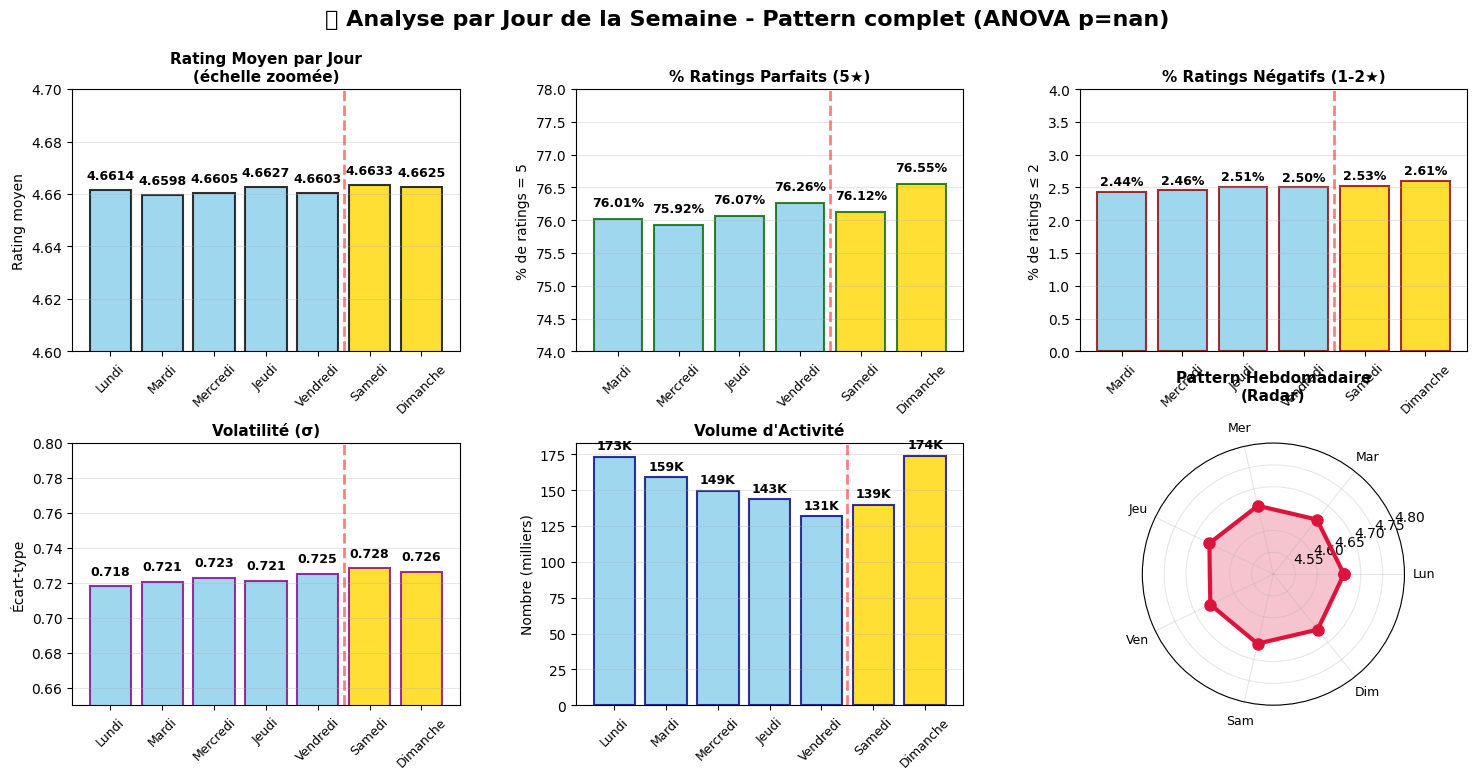

In [7]:
# Visualisation optimisée - Patterns par Jour de la Semaine
fig = plt.figure(figsize=(18, 8))

from matplotlib.gridspec import GridSpec
gs = GridSpec(2, 3, figure=fig, hspace=0.35, wspace=0.3)

# Couleurs par jour (nuance weekend)
day_colors = ['#87CEEB', '#87CEEB', '#87CEEB', '#87CEEB', '#87CEEB', '#FFD700', '#FFD700']

# Calcul % de 5★ par jour
pct_5_by_day = []
pct_neg_by_day = []
for day in range(7):
    day_data = df_clean.filter(pl.col("weekday") == day)["rating"].to_pandas()
    pct_5_by_day.append((day_data == 5).sum() / len(day_data) * 100)
    pct_neg_by_day.append((day_data <= 2).sum() / len(day_data) * 100)

# ============================================================================
# 1. RATING MOYEN PAR JOUR (échelle zoomée)
# ============================================================================
ax1 = fig.add_subplot(gs[0, 0])

bars = ax1.bar(weekday_patterns["day_name"], weekday_patterns["mean_rating"], 
               color=day_colors, edgecolor='black', linewidth=1.5, alpha=0.8)

for bar, val in zip(bars, weekday_patterns["mean_rating"]):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.003,
             f'{val:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax1.set_title("Rating Moyen par Jour\n(échelle zoomée)", fontsize=11, fontweight='bold')
ax1.set_ylabel("Rating moyen", fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([4.60, 4.70])
ax1.tick_params(axis='x', rotation=45, labelsize=9)
ax1.axvline(x=4.5, linestyle='--', color='red', alpha=0.5, linewidth=2)

# ============================================================================
# 2. % RATINGS PARFAITS (5★)
# ============================================================================
ax2 = fig.add_subplot(gs[0, 1])

bars = ax2.bar(weekday_patterns["day_name"], pct_5_by_day, 
               color=day_colors, edgecolor='darkgreen', linewidth=1.5, alpha=0.8)

for bar, val in zip(bars, pct_5_by_day):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.15,
             f'{val:.2f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax2.set_title("% Ratings Parfaits (5★)", fontsize=11, fontweight='bold')
ax2.set_ylabel("% de ratings = 5", fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim([74, 78])
ax2.tick_params(axis='x', rotation=45, labelsize=9)
ax2.axvline(x=4.5, linestyle='--', color='red', alpha=0.5, linewidth=2)

# ============================================================================
# 3. % RATINGS NÉGATIFS (1-2★)
# ============================================================================
ax3 = fig.add_subplot(gs[0, 2])

bars = ax3.bar(weekday_patterns["day_name"], pct_neg_by_day, 
               color=day_colors, edgecolor='darkred', linewidth=1.5, alpha=0.8)

for bar, val in zip(bars, pct_neg_by_day):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{val:.2f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax3.set_title("% Ratings Négatifs (1-2★)", fontsize=11, fontweight='bold')
ax3.set_ylabel("% de ratings ≤ 2", fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_ylim([0, 4])
ax3.tick_params(axis='x', rotation=45, labelsize=9)
ax3.axvline(x=4.5, linestyle='--', color='red', alpha=0.5, linewidth=2)

# ============================================================================
# 4. VOLATILITÉ PAR JOUR
# ============================================================================
ax4 = fig.add_subplot(gs[1, 0])

bars = ax4.bar(weekday_patterns["day_name"], weekday_patterns["std_rating"], 
               color=day_colors, edgecolor='purple', linewidth=1.5, alpha=0.8)

for bar, val in zip(bars, weekday_patterns["std_rating"]):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax4.set_title("Volatilité (σ)", fontsize=11, fontweight='bold')
ax4.set_ylabel("Écart-type", fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')
ax4.set_ylim([0.65, 0.80])
ax4.tick_params(axis='x', rotation=45, labelsize=9)
ax4.axvline(x=4.5, linestyle='--', color='red', alpha=0.5, linewidth=2)

# ============================================================================
# 5. VOLUME D'ACTIVITÉ
# ============================================================================
ax5 = fig.add_subplot(gs[1, 1])

bars = ax5.bar(weekday_patterns["day_name"], weekday_patterns["n_interactions"]/1000, 
               color=day_colors, edgecolor='navy', linewidth=1.5, alpha=0.8)

for bar, val in zip(bars, weekday_patterns["n_interactions"]/1000):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 3,
             f'{int(val)}K', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax5.set_title("Volume d'Activité", fontsize=11, fontweight='bold')
ax5.set_ylabel("Nombre (milliers)", fontsize=10)
ax5.grid(True, alpha=0.3, axis='y')
ax5.tick_params(axis='x', rotation=45, labelsize=9)
ax5.axvline(x=4.5, linestyle='--', color='red', alpha=0.5, linewidth=2)

# ============================================================================
# 6. RADAR CHART (pattern hebdomadaire)
# ============================================================================
ax6 = fig.add_subplot(gs[1, 2], projection='polar')

theta = np.linspace(0, 2*np.pi, len(weekday_patterns), endpoint=False)
theta = np.concatenate((theta, [theta[0]]))
values = np.concatenate((weekday_patterns["mean_rating"].values, [weekday_patterns["mean_rating"].values[0]]))

ax6.plot(theta, values, 'o-', linewidth=3, color='crimson', markersize=8)
ax6.fill(theta, values, alpha=0.25, color='crimson')
ax6.set_xticks(theta[:-1])
ax6.set_xticklabels([name[:3] for name in weekday_patterns["day_name"]], fontsize=9)
ax6.set_title("Pattern Hebdomadaire\n(Radar)", fontsize=11, fontweight='bold', pad=15)
ax6.set_ylim([4.5, 4.8])
ax6.grid(True, alpha=0.3)

plt.suptitle(f"📅 Analyse par Jour de la Semaine - Pattern complet (ANOVA p={p_value_anova:.4f})", 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()